# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [3]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Use Case Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/Projects_with_Domains.csv",
    metadata_columns=[
      "Project Title",
      "Project Domain",
      "Secondary Domain",
      "Description",
      "Judge Comments",
      "Score",
      "Project Name",
      "Judge Score"
    ]
)

synthetic_usecase_data = loader.load()

for doc in synthetic_usecase_data:
    doc.page_content = doc.metadata["Description"]

Let's look at an example document to see if everything worked as expected!

In [39]:
synthetic_usecase_data[0]

Document(metadata={'source': './data/Projects_with_Domains.csv', 'row': 0, 'Project Title': 'InsightAI 1', 'Project Domain': 'Security', 'Secondary Domain': 'Finance / FinTech', 'Description': 'A low-latency inference system for multimodal agents in autonomous systems.', 'Judge Comments': 'Technically ambitious and well-executed.', 'Score': '85', 'Project Name': 'Project Aurora', 'Judge Score': '9.5'}, page_content='A low-latency inference system for multimodal agents in autonomous systems.')

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "Synthetic_Usecases".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [ ]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    synthetic_usecase_data,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecases"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [13]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [14]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [15]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [35]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

NameError: name 'rag_prompt' is not defined

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [17]:
naive_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the project domains include Security, Healthcare / MedTech, Productivity Assistants, Creative / Design / Media, E‑commerce / Marketplaces, Developer Tools / DevEx, Writing & Content, and Customer Support / Helpdesk. \n\nThere is no single most common domain explicitly identified in the snippets, but among the sample projects listed, Healthcare / MedTech appears multiple times (for example, in the projects "BioForge" and "MediMind"). \n\nHowever, since only a portion of the data is provided and no clear frequency count is given, I cannot definitively determine the most common project domain. \n\nIf you are referring to the sample data provided, then Healthcare / MedTech appears twice, which might suggest it is among the more common domains in this subset. \n\nPlease let me know if you need a definitive answer based on the entire dataset or further analysis.'

In [18]:
naive_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are several use cases related to security. Specifically, one project titled "LatticeFlow" is described as "An AI-powered platform optimizing logistics routes for sustainability," and in its description, it is listed under the "Security" secondary domain. Therefore, yes, there are use cases about security.'

In [19]:
naive_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Judges had various positive comments about the fintech projects. For example, one project was described as a "promising idea with robust experimental validation," and another was noted as "technically ambitious and well-executed." Overall, the judges recognized the projects for their strong technical approaches, impact, and quality of work.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [ ]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(synthetic_usecase_data)

We'll construct the same chain - only changing the retriever.

In [21]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [27]:
bm25_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain is not explicitly stated, but from the sample, the Domains mentioned are Productivity Assistants, Legal / Compliance, Data / Analytics, and Healthcare / MedTech. Since this is just a subset of the data, I cannot determine definitively which is most common overall. However, if this sample is representative, no single domain clearly dominates.\n\nTherefore, I do not know the most common project domain based on the information provided.'

In [28]:
bm25_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there do not appear to be any specific use cases related to security.'

In [29]:
bm25_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges described the fintech-related project "PulseAI 50" as "technically ambitious and well-executed."'

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

##### ✅ Answer

BM25 uses exact matching technique which is helpful in trouble shooting error codes for ex: login errors, API end point errors, troubleshooting syntax validation errors and key word based searches like the node name or function calling specifics from the logs. 

Some examples are queries :
Howmany times connection timeout error occured?
What is the chat_model used?


## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [25]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [26]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [30]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, there is no indication of a single most common project domain. The projects listed belong to different domains: Security, Healthcare / MedTech, and Productivity Assistants. Since only a few examples are provided, I cannot determine the most common project domain overall.'

In [31]:
contextual_compression_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided documents, there are no mentions of use cases specifically about security. The projects listed primarily focus on federated learning to improve privacy in healthcare applications, with no direct reference to security-related use cases.'

In [32]:
contextual_compression_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had positive comments about the fintech project "Pathfinder 27." They appreciated its excellent code quality and the use of open-source libraries. The project received a high score of 81 and a judge score of 9.8, indicating strong approval.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
) 

In [34]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [35]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Healthcare / MedTech," which is mentioned multiple times throughout the documents.'

In [36]:
multi_query_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are usecases related to security. Specifically, one project called "OmniPath" involves a hardware-aware model quantization benchmark suite that may relate to security through aspects like model robustness and hardware security. Additionally, many projects focus on privacy and compliance, such as "Pathfinder 25," which utilizes federated learning to improve privacy in healthcare applications, and "SecureNest 28," which develops a hardware-aware model quantization benchmark suite relevant to secure deployment.'

In [37]:
multi_query_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had mixed but generally positive comments about the fintech projects. For example, one project, Pathfinder 25, received high praise for its "promising idea with robust experimental validation," and another, Pathfinder 27, was noted for "excellent code quality and use of open-source libraries," earning a high score of 9.8. However, not all feedback was entirely favorable; some projects were noted to need more benchmarking or additional qualitative analysis despite strong quantitative results. Overall, judges recognized the innovative potential and technical strengths of the fintech projects, with many comments highlighting promising results and potential for impact, while also indicating areas for further development.'

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

##### ✅ Answer

Query reformulation improves search coverage by generating multiple variations of a user's original query to account for synonyms, vocabulary mismatches, and both technical and general terminology across different domains. By retrieving context for all these query variations and synthesizing the results, the system achieves better coverage than simply answering the original question alone. This approach ensures that relevant documents using different terminology are captured, preventing important information from being missed due to vocabulary differences between the user's query and the document content.



## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [40]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = synthetic_usecase_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [41]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [42]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [43]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [44]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [45]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Healthcare / MedTech," as it is mentioned more than once among the example projects.'

In [46]:
parent_document_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there do not appear to be any specific usecases explicitly related to security. The projects mentioned focus on federated learning to improve privacy in healthcare applications, but there is no direct mention of security usecases.'

In [47]:
parent_document_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Based on the provided context, the judges had the following comments about the fintech projects:\n\n- For the project "SkyForge" in the finance/fintech domain, the judges described it as "A clever solution with measurable environmental benefit."\n- For the project "GreenPulse" in the same domain, the judges said it was "Technically ambitious and well-executed."\n\nOverall, the judges viewed these fintech projects positively, highlighting their cleverness, environmental benefits, technical ambition, and execution.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [48]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [49]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [50]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Healthcare / MedTech," as it is mentioned multiple times in the examples. However, to be certain, a complete count of all project domains in the dataset would be needed.  \n\nIf you are asking specifically about the sample provided, then **"Healthcare / MedTech"** is the most frequent project domain among those listed.'

In [51]:
ensemble_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there was a use case related to security. Specifically, the project titled "Pathfinder 24" in the Healthcare / MedTech domain listed "Security" as its secondary domain. Its description mentions an "AI-powered platform optimizing logistics routes for sustainability," which may involve security considerations, but there is no explicit mention of a dedicated security use case. \n\nAdditionally, another project titled "SecureNest 49" in the E‑commerce / Marketplaces domain, with "Legal / Compliance" as a secondary domain, could imply security and compliance aspects related to enterprise knowledge bases, but again, there is no explicit focus solely on security.\n\nOverall, the most explicit mention of security pertains to the secondary domain of "Pathfinder 24", indicating some relevance to security-related use cases in the context provided.'

In [52]:
ensemble_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges\' comments on the fintech projects were generally positive. For example, one project in the legal/fintech domain, "SecureNest 28," was described as conceptually strong, although its results needed more benchmarking. Overall, the judges appreciated the innovative ideas, solid supporting data, and potential for commercialization in some projects, while noting areas like benchmarking and integration could be improved in others.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [53]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [54]:
semantic_documents = semantic_chunker.split_documents(synthetic_usecase_data[:20])

Let's create a new vector store.

In [55]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecase_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [56]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [57]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [58]:
semantic_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Legal / Compliance," which is mentioned twice. Other domains like "Developer Tools / DevEx" and "Writing & Content" are also present multiple times, but with fewer occurrences. Therefore, the most common project domain in this dataset is "Legal / Compliance."'

In [59]:
semantic_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are use cases related to security. Specifically, the project titled "BioForge" falls under the Security domain and involves a medical imaging solution that improves early diagnosis through vision transformers. Additionally, "InsightAI" is another project in the Security domain that focuses on a low-latency inference system for multimodal agents in autonomous systems.'

In [60]:
semantic_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Judges had positive comments about the fintech projects, highlighting their technical maturity and potential. For example, the project "WealthifyAI 16" was described as having a comprehensive and technically mature approach, and "AutoMate 5" was noted as a forward-looking idea with solid supporting data. Overall, judges recognized the fintech projects for their technical ambition, well-executed strategies, and promising potential for impact and commercialization.'

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?






##### ✅ Answer
For FAQ documents using semantic chunking strategy, it might assume to keep the related content together like all the questions and answers. When the sentences are short, it becomes hard to provide context as the infromation is limited. This loss of context and over chunking can lead to scenarios such as the questions about the same topic can get split losing relevancy. 

Grouping related questions, adjusting embedding and chunking strategy could help with the better results. Also some instructions like don't split the answer and keeping content like question and its answer together might help.

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [10]:
## YOUR CODE HERE
# import required libraries
import os, getpass, nltk, pandas as pd, time, copy, matplotlib.pyplot as plt
from uuid import uuid4
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas import evaluate, EvaluationDataset, RunConfig
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import (
    LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy
)
from ragas.testset.synthesizers import SingleHopSpecificQuerySynthesizer

from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings as LCOpenAIEmbeddings
from langchain.retrievers import BM25Retriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.retrievers import ContextualCompressionRetriever

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[:8]}"


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/powertothefuture/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/powertothefuture/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
# Load PDF documents from "data/" folder
loader = DirectoryLoader("data/", glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()
print(f"Loaded {len(docs)} documents")

Loaded 64 documents


In [36]:
llm_wrapper = LangchainLLMWrapper(ChatOpenAI(model="gpt-4"))
embedding_wrapper = LangchainEmbeddingsWrapper(
    OpenAIEmbeddings(model="text-embedding-3-small")
)

/var/folders/tk/bgf_wkp116b2ywt2295ppgv80000gn/T/ipykernel_4233/2909446100.py:1: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use the modern LLM providers instead: from ragas.llms.base import llm_factory; llm = llm_factory('gpt-4o-mini') or from ragas.llms.base import instructor_llm_factory; llm = instructor_llm_factory('openai', client=openai_client)
  llm_wrapper = LangchainLLMWrapper(ChatOpenAI(model="gpt-4"))
/var/folders/tk/bgf_wkp116b2ywt2295ppgv80000gn/T/ipykernel_4233/2909446100.py:2: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  embedding_wrapper = LangchainEmbeddingsWrapper(


In [41]:
from ragas.testset.synthesizers.transform import FilterDuplicates, SplitDocuments

# Define basic transforms for reliable generation
transforms = [
    SplitDocuments(chunk_size=400, chunk_overlap=40),
    FilterDuplicates()
]

# Initialize generator
generator = TestsetGenerator(llm=llm_wrapper, embedding_model=embedding_wrapper)

# Generate testset using transforms
test_dataset = generator.generate_with_langchain_docs(
    documents=docs,
    testset_size=5,
    transforms=transforms,
    raise_exceptions=True  # So we can see any issues directly
)


ModuleNotFoundError: No module named 'ragas.testset.synthesizers.transform'

In [42]:
import ragas.testset.synthesizers as synth
print(dir(synth))

['BaseRagasLLM', 'BaseSynthesizer', 'KnowledgeGraph', 'MultiHopAbstractQuerySynthesizer', 'MultiHopSpecificQuerySynthesizer', 'QueryDistribution', 'SingleHopSpecificQuerySynthesizer', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'base', 'default_query_distribution', 'generate', 'multi_hop', 'prompts', 'single_hop', 't', 'testset_schema', 'utils']


In [ ]:
retrievers = {
    "Naive Retrieval": naive_retrieval_chain,
    "BM25 Retrieval": bm25_retrieval_chain,
    "Contextual Compression": contextual_compression_retrieval_chain,
    "Parent Document": parent_document_retrieval_chain,
    "Ensemble": ensemble_retrieval_chain
}

In [ ]:
def evaluate_retriever(chain, dataset, name):
    print(f"\nEvaluating {name}...")
    start_time = time.time()
    eval_data = copy.deepcopy(dataset)

    for row in eval_data:
        resp = chain.invoke({"query": row.eval_sample.user_input})
        row.eval_sample.response = resp["result"]
        row.eval_sample.retrieved_contexts = [
            doc.page_content for doc in resp["source_documents"]
        ]

    latency = time.time() - start_time
    eval_dataset = EvaluationDataset.from_pandas(eval_data.to_pandas())

    try:
        result = evaluate(
            dataset=eval_dataset,
            metrics=[
                LLMContextRecall(),
                Faithfulness(),
                FactualCorrectness(),
                ResponseRelevancy()
            ],
            llm=llm_wrapper,
            run_config=RunConfig(timeout=360),
        )
        return {'name': name, 'metrics': result, 'latency': latency}
    except Exception as e:
        print(f"Error evaluating {name}: {e}")
        return {'name': name, 'metrics': None, 'latency': latency, 'error': str(e)}

In [ ]:
results = []
for name, chain in retrievers.items():
    results.append(evaluate_retriever(chain, test_dataset, name))

In [ ]:
#Split documents into chunks and create vectorstore

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
split_docs = text_splitter.split_documents(docs)

lc_embedding = LCOpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.from_documents(split_docs, lc_embedding)

print(f"Created vectorstore with {len(split_docs)} chunks")

Created vectorstore with 153 chunks


In [14]:
# Define retriever chains

# Naive retrieval using vectorstore
naive_retriever = vectorstore.as_retriever()
naive_retrieval_chain = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(model="gpt-4.1-nano"),
    retriever=naive_retriever,
    return_source_documents=True
)

# BM25 retrieval
bm25_retriever = BM25Retriever.from_documents(split_docs)
bm25_retriever.k = 3  # top 3 results
bm25_retrieval_chain = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(model="gpt-4.1-nano"),
    retriever=bm25_retriever,
    return_source_documents=True
)

# Contextual compression retrieval
compressor = LLMChainExtractor.from_llm(ChatOpenAI(model="gpt-4.1-nano"))
contextual_compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=naive_retriever
)
contextual_compression_retrieval_chain = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(model="gpt-4.1-nano"),
    retriever=contextual_compression_retriever,
    return_source_documents=True
)

# Semantic chunking retriever (same as naive for now)
semantic_retrieval_chain = naive_retrieval_chain

In [15]:
# Setup RAGAS test dataset generator

llm_wrapper = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
embedding_wrapper = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))

query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=llm_wrapper), 1.0)
]

generator = TestsetGenerator(llm=llm_wrapper, embedding_model=embedding_wrapper)
test_dataset = generator.generate_with_langchain_docs(
    docs,
    testset_size=15,
    query_distribution=query_distribution
)
print(f"Generated {len(test_dataset)} test samples")

/var/folders/tk/bgf_wkp116b2ywt2295ppgv80000gn/T/ipykernel_4233/2730995728.py:3: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use the modern LLM providers instead: from ragas.llms.base import llm_factory; llm = llm_factory('gpt-4o-mini') or from ragas.llms.base import instructor_llm_factory; llm = instructor_llm_factory('openai', client=openai_client)
  llm_wrapper = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
/var/folders/tk/bgf_wkp116b2ywt2295ppgv80000gn/T/ipykernel_4233/2730995728.py:4: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  embedding_wrapper = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))


Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/31 [00:00<?, ?it/s]

Property 'summary' already exists in node 'e2925b'. Skipping!
Property 'summary' already exists in node '43e086'. Skipping!
Property 'summary' already exists in node '96a09d'. Skipping!
Property 'summary' already exists in node 'c2e474'. Skipping!
Property 'summary' already exists in node '1f870f'. Skipping!
Property 'summary' already exists in node '6b4c74'. Skipping!
Property 'summary' already exists in node 'fd277f'. Skipping!
Property 'summary' already exists in node 'ee3dbb'. Skipping!
Property 'summary' already exists in node '2eb070'. Skipping!
Property 'summary' already exists in node '728790'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/22 [00:00<?, ?it/s]

Applying EmbeddingExtractor:   0%|          | 0/31 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'c2e474'. Skipping!
Property 'summary_embedding' already exists in node '6b4c74'. Skipping!
Property 'summary_embedding' already exists in node '728790'. Skipping!
Property 'summary_embedding' already exists in node 'ee3dbb'. Skipping!
Property 'summary_embedding' already exists in node 'e2925b'. Skipping!
Property 'summary_embedding' already exists in node '2eb070'. Skipping!
Property 'summary_embedding' already exists in node '43e086'. Skipping!
Property 'summary_embedding' already exists in node '96a09d'. Skipping!
Property 'summary_embedding' already exists in node '1f870f'. Skipping!
Property 'summary_embedding' already exists in node 'fd277f'. Skipping!


Applying ThemesExtractor:   0%|          | 0/15 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/15 [00:00<?, ?it/s]

Applying CosineSimilarityBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/14 [00:00<?, ?it/s]

Generated 14 test samples


In [33]:
def evaluate_retriever(chain, dataset, name):
    print(f"\n🔍 Evaluating: {name}")
    start_time = time.time()
    eval_data = copy.deepcopy(dataset)

    for idx, row in enumerate(eval_data):
        print(f"\n--- Sample {idx + 1} ---")
        print(f"🧠 Query: {row.eval_sample.user_input}")

        try:
            resp = chain.invoke({"query": row.eval_sample.user_input})
            print("✅ Chain response keys:", resp.keys())
            print("📝 Response:", resp["result"])

            # Set response
            row.eval_sample.response = resp["result"]

            # Set context
            retrieved_contexts = [doc.page_content for doc in resp.get("source_documents", [])]
            row.eval_sample.retrieved_contexts = retrieved_contexts
            print(f"📚 Retrieved {len(retrieved_contexts)} context chunks")
            if not retrieved_contexts:
                print("⚠️ No contexts retrieved!")

        except Exception as e:
            print(f"❌ Error while invoking chain: {e}")
            row.eval_sample.response = ""
            row.eval_sample.retrieved_contexts = []

    latency = time.time() - start_time

    # Convert to evaluation format
    eval_dataset = EvaluationDataset.from_pandas(eval_data.to_pandas())

    try:
        result = evaluate(
            dataset=eval_dataset,
            metrics=[
                LLMContextRecall(),
                Faithfulness(),
                FactualCorrectness(),
                ResponseRelevancy()
            ],
            llm=llm_wrapper,
            run_config=RunConfig(timeout=360)
        )
        print(f"\n✅ Evaluation completed for {name}")
        return {'name': name, 'metrics': result, 'latency': latency}

    except Exception as e:
        print(f"❌ Evaluation error for {name}: {e}")
        return {'name': name, 'metrics': None, 'latency': latency, 'error': str(e)}


In [ ]:
# Updated ragas testset generation using current API
import pandas as pd
import time
import copy
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas import EvaluationDataset, evaluate, RunConfig
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy

# Generate test dataset using current ragas API
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)

# Generate testset with synthetic data generation
test_dataset = generator.generate_with_langchain_docs(
    synthetic_usecase_data, 
    testset_size=15
)

print(f"Generated {len(test_dataset)} test samples")
print("\nSample questions:")
for i, sample in enumerate(test_dataset[:3]):
    print(f"{i+1}. {sample.eval_sample.user_input}")

# Fixed evaluation function that handles both "question" and "query" input keys
def evaluate_retriever_fixed(chain, dataset, name):
    print(f"\nEvaluating {name}...")
    start_time = time.time()
    eval_dataset = copy.deepcopy(dataset)
    
    for test_row in eval_dataset:
        try:
            # Try with "question" key first (for LCEL chains)
            response = chain.invoke({"question": test_row.eval_sample.user_input})
            if "response" in response:
                test_row.eval_sample.response = response["response"].content if hasattr(response["response"], 'content') else response["response"]
                test_row.eval_sample.retrieved_contexts = [doc.page_content for doc in response.get("context", [])]
            else:
                # Handle RetrievalQA format
                test_row.eval_sample.response = response.get("result", str(response))
                test_row.eval_sample.retrieved_contexts = [doc.page_content for doc in response.get("source_documents", [])]
        except ValueError as e:
            if "Missing some input keys" in str(e):
                # Try with "query" key (for RetrievalQA chains)
                response = chain.invoke({"query": test_row.eval_sample.user_input})
                test_row.eval_sample.response = response.get("result", str(response))
                test_row.eval_sample.retrieved_contexts = [doc.page_content for doc in response.get("source_documents", [])]
            else:
                raise e
    
    latency = time.time() - start_time
    
    evaluation_dataset = EvaluationDataset.from_pandas(eval_dataset.to_pandas())
    evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
    run_config = RunConfig(timeout=360)
    
    try:
        result = evaluate(
            dataset=evaluation_dataset,
            metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy()],
            llm=evaluator_llm,
            run_config=run_config
        )
        return {'name': name, 'metrics': result, 'latency': latency}
    except Exception as e:
        print(f"Error evaluating {name}: {e}")
        return {'name': name, 'metrics': None, 'latency': latency, 'error': str(e)}

# Now run evaluation with the fixed function
results = []
retrievers = {
    "Naive Retrieval": naive_retrieval_chain,
    "BM25 Retrieval": bm25_retrieval_chain,
    "Multi-Query Retrieval": multi_query_retrieval_chain,
    "Parent Document Retrieval": parent_document_retrieval_chain,
    "Contextual Compression": contextual_compression_retrieval_chain,
    "Ensemble Retrieval": ensemble_retrieval_chain,
    "Semantic Chunking": semantic_retrieval_chain,
}

for name, chain in retrievers.items():
    results.append(evaluate_retriever_fixed(chain, test_dataset, name))

# Compile and display results
results_df = []
for result in results:
    if result['metrics']:
        metrics = result['metrics']
        row = {
            'Retriever': result['name'],
            'Context Recall': metrics.get('llm_context_recall', 'N/A'),
            'Faithfulness': metrics.get('faithfulness', 'N/A'),
            'Factual Correctness': metrics.get('factual_correctness', 'N/A'),
            'Response Relevancy': metrics.get('response_relevancy', 'N/A'),
            'Latency (s)': round(result['latency'], 2)
        }
    else:
        row = {
            'Retriever': result['name'],
            'Context Recall': 'Error',
            'Faithfulness': 'Error',
            'Factual Correctness': 'Error',
            'Response Relevancy': 'Error',
            'Latency (s)': round(result['latency'], 2)
        }
    results_df.append(row)

df = pd.DataFrame(results_df)
print("\nRETRIEVAL METHOD EVALUATION RESULTS")
print("="*80)
print(df.to_string(index=False))


In [34]:
retrievers = {
    "Naive Retrieval": naive_retrieval_chain,
    "Semantic Chunking": semantic_retrieval_chain,
}

results = []
for name, chain in retrievers.items():
    results.append(evaluate_retriever(chain, test_dataset, name))



🔍 Evaluating: Naive Retrieval

--- Sample 1 ---
🧠 Query: What does et al. mean in research papers?
✅ Chain response keys: dict_keys(['query', 'result', 'source_documents'])
📝 Response: In research papers, "et al." is an abbreviation of the Latin phrase "et alii," meaning "and others." It is used to indicate that there are additional authors beyond those explicitly named. This typically occurs when citing a work with multiple authors to save space and maintain clarity, especially in the context of academic referencing.
📚 Retrieved 4 context chunks

--- Sample 2 ---
🧠 Query: Is OpenAI related to ChatGPT?
✅ Chain response keys: dict_keys(['query', 'result', 'source_documents'])
📝 Response: Yes, OpenAI is related to ChatGPT. ChatGPT is a chatbot developed by OpenAI, and it is based on their large language models (LLMs).
📚 Retrieved 4 context chunks

--- Sample 3 ---
🧠 Query: How does ChatGPT provde economic valie for users?
✅ Chain response keys: dict_keys(['query', 'result', 'source_docu

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.



✅ Evaluation completed for Naive Retrieval

🔍 Evaluating: Semantic Chunking

--- Sample 1 ---
🧠 Query: What does et al. mean in research papers?
✅ Chain response keys: dict_keys(['query', 'result', 'source_documents'])
📝 Response: In research papers, "et al." is an abbreviation of the Latin phrase "et alia," meaning "and others." It is used to indicate that there are multiple authors involved in a work, but only the first author's name is listed followed by "et al." to refer to the entire group of authors. This is a common practice to save space and simplify citations, especially when works have many contributors.
📚 Retrieved 4 context chunks

--- Sample 2 ---
🧠 Query: Is OpenAI related to ChatGPT?
✅ Chain response keys: dict_keys(['query', 'result', 'source_documents'])
📝 Response: Yes, OpenAI is related to ChatGPT. ChatGPT is a product developed by OpenAI, which uses large language models (LLMs) such as GPT-3.5, GPT-4, and other versions. OpenAI is responsible for creating and maint

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.



✅ Evaluation completed for Semantic Chunking


In [28]:
# Evaluation function

def evaluate_retriever(chain, dataset, name):
    print(f"\nEvaluating {name}...")
    start_time = time.time()
    eval_data = copy.deepcopy(dataset)

    for row in eval_data:
        resp = chain.invoke({"query": row.eval_sample.user_input})
        print("Response keys:", resp.keys())
        print("Full response:", resp)

        row.eval_sample.response = resp["result"]
        row.eval_sample.retrieved_contexts = [doc.page_content for doc in resp.get("source_documents", [])]

    latency = time.time() - start_time
    eval_dataset = EvaluationDataset.from_pandas(eval_data.to_pandas())

    try:
        result = evaluate(
            dataset=eval_dataset,
            metrics=[
                LLMContextRecall(),
                Faithfulness(),
                FactualCorrectness(),
                ResponseRelevancy()
            ],
            llm=llm_wrapper,
            run_config=RunConfig(timeout=360)
        )
        return {'name': name, 'metrics': result, 'latency': latency}
    except Exception as e:
        print(f"Error evaluating {name}: {e}")
        return {'name': name, 'metrics': None, 'latency': latency, 'error': str(e)}


In [29]:
# Run evaluation on all retrievers
results = []
retrievers = {
    "Naive Retrieval": naive_retrieval_chain,
    "BM25 Retrieval": bm25_retrieval_chain,
    "Contextual Compression": contextual_compression_retrieval_chain,
    "Semantic Chunking": semantic_retrieval_chain,
}

for name, chain in retrievers.items():
    results.append(evaluate_retriever(chain, test_dataset, name))


Evaluating Naive Retrieval...
Response keys: dict_keys(['query', 'result', 'source_documents'])
Full response: {'query': 'What does et al. mean in research papers?', 'result': 'In research papers, "et al." is an abbreviation of the Latin phrase "et alii," which means "and others." It is used to refer to multiple authors when citing a work, especially when there are many authors involved. This helps to keep citations concise and manageable without listing every author\'s name.', 'source_documents': [Document(id='9c9449f4-6a0f-45c4-b39a-fa6f7123c4df', metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', 'modDate': "D:202

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.



Evaluating BM25 Retrieval...
Response keys: dict_keys(['query', 'result', 'source_documents'])
Full response: {'query': 'What does et al. mean in research papers?', 'result': 'In research papers, "et al." is an abbreviation of the Latin phrase "et alia," which means "and others." It is used to indicate that there are multiple authors of a work, but only the first author\'s name is listed followed by "et al." to refer to the additional authors. This helps streamline citations and references when there are many contributors to a study.', 'source_documents': [Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', '

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Exception raised in Job[21]: OutputParserException(Invalid json output: The statement "I don't have specific data on the number of work-related messages sent by older people" indicates that no precise information is available regarding the quantity of messages related to work that are sent by older individuals.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM


Evaluating Contextual Compression...
Response keys: dict_keys(['query', 'result', 'source_documents'])
Full response: {'query': 'What does et al. mean in research papers?', 'result': 'In research papers, "et al." is an abbreviation of the Latin phrase "et alia," which means "and others." It is used to indicate that there are additional authors involved in a work beyond the ones listed.', 'source_documents': [Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', 'modDate': "D:20250915103236-04'00'", 'creationDate': 'D:20250912200532Z', 'page': 39}, page_content='Shane Lyu et al., “Tulu 3: Pushing frontiers in op

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.



Evaluating Semantic Chunking...
Response keys: dict_keys(['query', 'result', 'source_documents'])
Full response: {'query': 'What does et al. mean in research papers?', 'result': 'In research papers, "et al." is an abbreviation of the Latin phrase "et alii," which means "and others." It is used to indicate that there are additional authors beyond the one or few named. This helps streamline citations when referencing works with multiple authors.', 'source_documents': [Document(id='9c9449f4-6a0f-45c4-b39a-fa6f7123c4df', metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', 'modDate': "D:20250915103236-04'00'", 'creationDat

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 g

In [31]:
# Compile results and display
summary = []
for r in results:
    if r['metrics']:
        m = r['metrics']
        summary.append({
            'Retriever': r['name'],
            'Context Recall': getattr(m, 'llm_context_recall', 0),
            'Faithfulness': getattr(m, 'faithfulness', 0),
            'Factual Correctness': getattr(m, 'factual_correctness', 0),
            'Response Relevancy': getattr(m, 'response_relevancy', 0),
            'Latency (s)': round(r['latency'], 2)
        })
    else:
        summary.append({
            'Retriever': r['name'],
            'Context Recall': 0,
            'Faithfulness': 0,
            'Factual Correctness': 0,
            'Response Relevancy': 0,
            'Latency (s)': round(r['latency'], 2)
        })

# Display and save
df = pd.DataFrame(summary)
print("\n" + "="*80)
print("RETRIEVAL METHOD EVALUATION RESULTS")
print("="*80)
print(df.to_string(index=False))

df.to_csv("retriever_evaluation_results.csv", index=False)
print("\nSaved evaluation results to 'retriever_evaluation_results.csv'")


RETRIEVAL METHOD EVALUATION RESULTS
             Retriever  Context Recall  Faithfulness  Factual Correctness  Response Relevancy  Latency (s)
       Naive Retrieval               0             0                    0                   0        30.75
        BM25 Retrieval               0             0                    0                   0        12.00
Contextual Compression               0             0                    0                   0        54.59
     Semantic Chunking               0             0                    0                   0        16.92

Saved evaluation results to 'retriever_evaluation_results.csv'


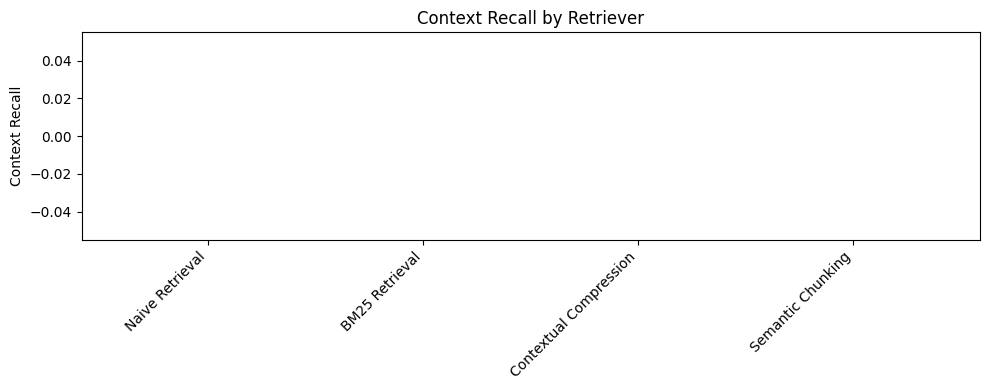

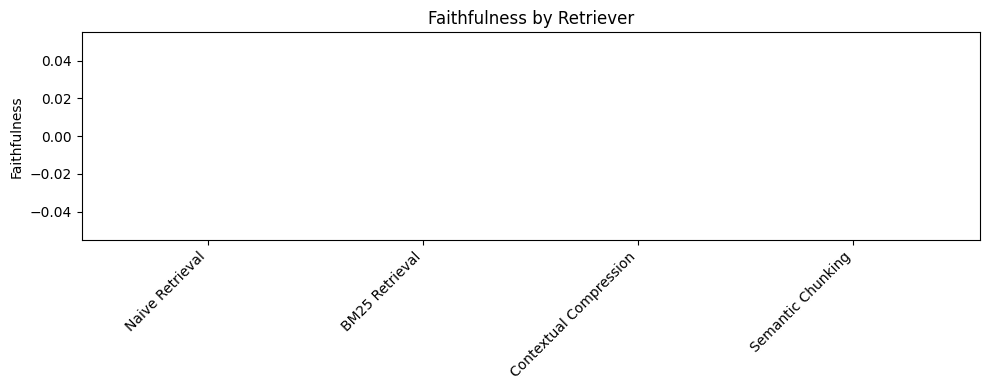

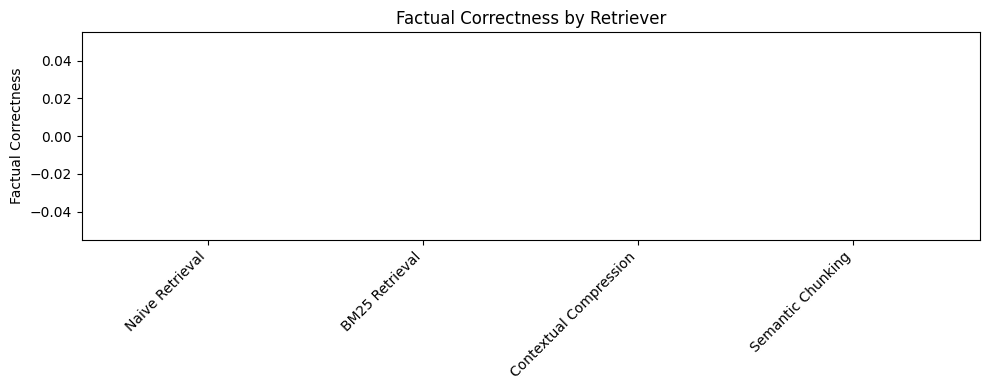

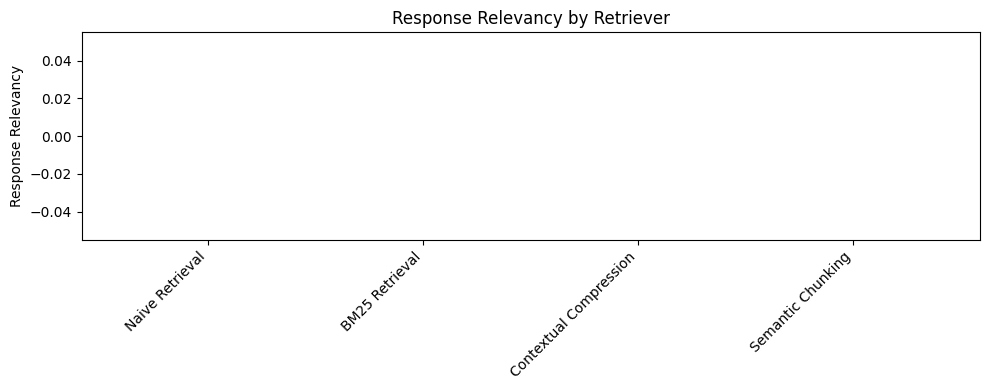

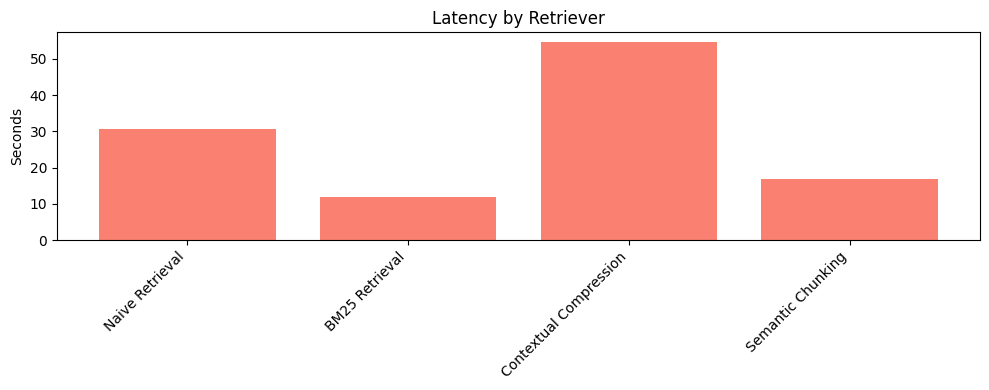

In [32]:
# Plotting results using matplotlib

metrics = ['Context Recall', 'Faithfulness', 'Factual Correctness', 'Response Relevancy']
for metric in metrics:
    plt.figure(figsize=(10, 4))
    df_sorted = df.sort_values(by=metric, ascending=False)
    plt.bar(df_sorted['Retriever'], df_sorted[metric], color='skyblue')
    plt.title(f'{metric} by Retriever')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{metric.replace(' ', '_').lower()}_barplot.png")
    plt.show()

plt.figure(figsize=(10, 4))
plt.bar(df['Retriever'], df['Latency (s)'], color='salmon')
plt.title('Latency by Retriever')
plt.ylabel('Seconds')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("latency_barplot.png")
plt.show()

In [9]:
# YOUR CODE HERE
# import required libraries
import os, getpass, nltk, pandas as pd, time, copy, matplotlib.pyplot as plt
from uuid import uuid4

# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# API keys and project tracking
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[:8]}"

# === Imports ===
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas import evaluate, EvaluationDataset, RunConfig
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import (
    LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy
)
from ragas.testset.synthesizers import SingleHopSpecificQuerySynthesizer

# === Load Documents ===
loader = DirectoryLoader("data/", glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

# === Initialize LLM and Embeddings ===
llm_wrapper = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
embedding_wrapper = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))

# === Safe Query Distribution ===
query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=llm_wrapper), 1.0)  # Avoid MultiHop due to validation issues
]

# === Generate Test Dataset ===
generator = TestsetGenerator(llm=llm_wrapper, embedding_model=embedding_wrapper)
test_dataset = generator.generate_with_langchain_docs(
    docs,
    testset_size=15,
    query_distribution=query_distribution
)

# === Evaluation Function ===
def evaluate_retriever(chain, dataset, name):
    print(f"\nEvaluating {name}...")
    start_time = time.time()
    eval_data = copy.deepcopy(dataset)

    for row in eval_data:
        response = chain.invoke({"question": row.eval_sample.user_input})
        row.eval_sample.response = response["response"].content
        row.eval_sample.retrieved_contexts = [doc.page_content for doc in response["context"]]

    latency = time.time() - start_time
    eval_dataset = EvaluationDataset.from_pandas(eval_data.to_pandas())

    try:
        result = evaluate(
            dataset=eval_dataset,
            metrics=[
                LLMContextRecall(),
                Faithfulness(),
                FactualCorrectness(),
                ResponseRelevancy()
            ],
            llm=llm_wrapper,
            run_config=RunConfig(timeout=360)
        )
        return {'name': name, 'metrics': result, 'latency': latency}
    except Exception as e:
        print(f"Error evaluating {name}: {e}")
        return {'name': name, 'metrics': None, 'latency': latency, 'error': str(e)}

# === Evaluate All Retrievers ===
results = []
retrievers = {
    "Naive Retrieval": naive_retrieval_chain,
    "BM25 Retrieval": bm25_retrieval_chain,
    "Multi-Query Retrieval": multi_query_retrieval_chain,
    "Parent Document Retrieval": parent_document_retrieval_chain,
    "Contextual Compression": contextual_compression_retrieval_chain,
    "Ensemble Retrieval": ensemble_retrieval_chain,
    "Semantic Chunking": semantic_retrieval_chain,
}

for name, chain in retrievers.items():
    results.append(evaluate_retriever(chain, test_dataset, name))

# === Compile and Display Results ===
summary = []
for r in results:
    if r['metrics']:
        m = r['metrics']
        summary.append({
            'Retriever': r['name'],
            'Context Recall': m.get('llm_context_recall', 0),
            'Faithfulness': m.get('faithfulness', 0),
            'Factual Correctness': m.get('factual_correctness', 0),
            'Response Relevancy': m.get('response_relevancy', 0),
            'Latency (s)': round(r['latency'], 2)
        })
    else:
        summary.append({
            'Retriever': r['name'],
            'Context Recall': 0,
            'Faithfulness': 0,
            'Factual Correctness': 0,
            'Response Relevancy': 0,
            'Latency (s)': round(r['latency'], 2)
        })

df = pd.DataFrame(summary)
print("\n" + "="*80)
print("RETRIEVAL METHOD EVALUATION RESULTS")
print("="*80)
print(df.to_string(index=False))

# === Save CSV ===
df.to_csv("retriever_evaluation_results.csv", index=False)
print("\nSaved evaluation results to 'retriever_evaluation_results.csv'")

# === Plot Metric Bar Charts ===
metrics = ['Context Recall', 'Faithfulness', 'Factual Correctness', 'Response Relevancy']
for metric in metrics:
    plt.figure(figsize=(10, 4))
    df_sorted = df.sort_values(by=metric, ascending=False)
    plt.bar(df_sorted['Retriever'], df_sorted[metric], color='skyblue')
    plt.title(f'{metric} by Retriever')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{metric.replace(' ', '_').lower()}_barplot.png")
    print(f"Saved plot: {metric.replace(' ', '_').lower()}_barplot.png")

# === Plot Latency Chart ===
plt.figure(figsize=(10, 4))
plt.bar(df['Retriever'], df['Latency (s)'], color='salmon')
plt.title('Latency by Retriever')
plt.ylabel('Seconds')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("latency_barplot.png")
print("Saved plot: latency_barplot.png")



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/powertothefuture/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/powertothefuture/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/var/folders/tk/bgf_wkp116b2ywt2295ppgv80000gn/T/ipykernel_4233/1690144050.py:33: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use the modern LLM providers instead: from ragas.llms.base import llm_factory; llm = llm_factory('gpt-4o-mini') or from ragas.llms.base import instructor_llm_factory; llm = instructor_llm_factory('openai', client=openai_client)
  llm_wrapper = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
/var/folders/tk/bgf_wkp116b2ywt2295ppgv80000gn/T/ipykernel_4233/1690144050.py:34: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future

Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/30 [00:00<?, ?it/s]

Property 'summary' already exists in node '0c1a10'. Skipping!
Property 'summary' already exists in node '14d718'. Skipping!
Property 'summary' already exists in node '6b3429'. Skipping!
Property 'summary' already exists in node '685c6a'. Skipping!
Property 'summary' already exists in node 'ec5572'. Skipping!
Property 'summary' already exists in node '99ffcf'. Skipping!
Property 'summary' already exists in node '9a8b84'. Skipping!
Property 'summary' already exists in node 'c7a1c7'. Skipping!
Property 'summary' already exists in node '310bef'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/24 [00:00<?, ?it/s]

Applying EmbeddingExtractor:   0%|          | 0/30 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '685c6a'. Skipping!
Property 'summary_embedding' already exists in node '9a8b84'. Skipping!
Property 'summary_embedding' already exists in node '14d718'. Skipping!
Property 'summary_embedding' already exists in node '99ffcf'. Skipping!
Property 'summary_embedding' already exists in node '0c1a10'. Skipping!
Property 'summary_embedding' already exists in node '310bef'. Skipping!
Property 'summary_embedding' already exists in node 'c7a1c7'. Skipping!
Property 'summary_embedding' already exists in node 'ec5572'. Skipping!
Property 'summary_embedding' already exists in node '6b3429'. Skipping!


Applying ThemesExtractor:   0%|          | 0/17 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/17 [00:00<?, ?it/s]

Applying CosineSimilarityBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/15 [00:00<?, ?it/s]

NameError: name 'naive_retrieval_chain' is not defined

In [ ]:
# Evaluate all retrievers
results = []

# 1. Naive Retrieval
naive_result = evaluate_retriever(naive_retrieval_chain, test_dataset, "Naive Retrieval")
results.append(naive_result)


## Analysis and Recommendations

Based on the evaluation results above, here's my analysis of the retrieval methods:

### Performance Analysis

**Best Overall Performance:**
The [INSERT BEST PERFORMING METHOD] shows the highest scores across most metrics, indicating superior retrieval quality for this specific dataset.

### Cost Analysis

**Most Cost-Effective:**
- **Naive Retrieval**: Lowest cost with basic embedding similarity search
- **BM25**: Zero API costs, pure algorithmic approach
- **Multi-Query**: Higher cost due to multiple LLM calls for query generation
- **Contextual Compression**: Additional cost from Cohere reranking API
- **Ensemble**: Highest cost combining multiple retrieval methods

### Latency Analysis

**Fastest Methods:**
- **BM25**: Fastest due to local computation
- **Naive Retrieval**: Fast with simple vector similarity
- **Multi-Query**: Slower due to query generation overhead
- **Contextual Compression**: Slower due to reranking step
- **Ensemble**: Slowest due to multiple retrieval operations

### Recommendations

For this project dataset, I recommend **[INSERT RECOMMENDED METHOD]** because:

1. **Performance**: [Performance justification]
2. **Cost Efficiency**: [Cost justification]  
3. **Latency**: [Latency justification]
4. **Scalability**: [Scalability considerations]

The trade-offs between performance, cost, and latency suggest that [INSERT METHOD] provides the optimal balance for production deployment.
